In [1]:
cd ..

/home/janek/reasonable-embeddings


In [2]:
import numpy as np
import pandas as pd
import torch as T
import torch.nn.functional as F
import torch.nn as nn
from sklearn import metrics
from sklearn.decomposition import PCA
from tqdm import tqdm

from src.reasoner_mod import *
from src.simplefact import *
from src.simplefact.syntax import *
from src.reasoner import *
from src.generate import *
from src.utils import *
from src.vis import *
import random
seed = 2022
random.seed(seed)

In [3]:
onto_paths = 'african-wildlife.ofn exchangemodel-noimport.ofn stuff-noimport.ofn swo-noimport.ofn ontodt-noimport.ofn pizza.ofn'.split()
onto_names = 'wildlife demacare stuff swo ontodt pizza'.split()
ontos = []
facts = []
for path in onto_paths:
    onto = load_ofn('local/out/dataset/' + path, silent=True)
    fact = Reasoner.from_onto(onto, timeout=None)
    facts.append(fact)
    ontos.append(onto)
    print(path, '\t', onto)

FaCT++.Kernel: Reasoner for the SROIQ(D) Description Logic, 64-bit
Copyright (C) Dmitry Tsarkov, 2002-2017. Version 1.7.0-SNAPSHOT (01 January 2017)


african-wildlife.ofn 	 <Onto 30 concepts, 5 roles, 49 axioms>
exchangemodel-noimport.ofn 	 <Onto 260 concepts, 53 roles, 369 axioms>
stuff-noimport.ofn 	 <Onto 192 concepts, 46 roles, 314 axioms>
swo-noimport.ofn 	 <Onto 4067 concepts, 39 roles, 7140 axioms>
ontodt-noimport.ofn 	 <Onto 405 concepts, 8 roles, 921 axioms>
pizza.ofn 	 <Onto 99 concepts, 4 roles, 287 axioms>


In [4]:
def make_dataset(onto, fact, n_queries=16000, max_depth=4):
    rng = np.random.default_rng(seed)
    Nc, Nr = onto.n_concepts, onto.n_roles
    gen = AxiomGenerator(rng=rng, n_concepts=Nc, n_roles=Nr, max_depth=max_depth, p_atomic=0.95)

    queries, answers, qset = [], [], set()
    while len(queries) < n_queries:
        axiom = gen()
        axiom_core = core(axiom)
        if axiom_core in qset: continue
        answer = fact.check_axiom(axiom)
        queries.append(axiom_core); answers.append(int(answer)); qset.add(axiom_core)
        
    return queries, answers

In [5]:
rng = np.random.default_rng(seed)
balances = {}
idx_tr, X_tr, y_tr = [], [], []
for i, (onto, fact, onto_name) in enumerate(zip(ontos, facts, onto_names)):
    query_feature_length = 2
    X_tr_onto, y_tr_onto = make_dataset(onto, fact, 16000, query_feature_length)

    idx_tr += [i]*len(X_tr_onto)
    print(onto_name, '- balance', np.round(np.mean(y_tr_onto), 4))
    balances[onto_name] = np.round(np.mean(y_tr_onto), 4)
    X_tr += X_tr_onto
    y_tr += y_tr_onto
    
data_tr = idx_tr, X_tr, y_tr = jointshuffle(rng, idx_tr, X_tr, y_tr)

wildlife - balance 0.1224
demacare - balance 0.0449
stuff - balance 0.2651
swo - balance 0.3039
ontodt - balance 0.0849
pizza - balance 0.4466


In [6]:
def adjust_label_distribution(onto, fact, X, y, target_balance=0.1, query_length=3, max_iter=25):

    decay =0.96
    part =0.6
    tolerance = 0.015 if target_balance > 0.125 else 0.0075
    for i in range(max_iter):
        balance = np.mean(y)
        if abs(balance - target_balance) <= tolerance:
            break
        
        if balance > target_balance:
            majority_class = 1
        else:
            majority_class = 0
        
        excess =  int(part * y.count(majority_class))
        if excess == 0:
            continue
        
        indices = list(range(len(y)))
        indices_to_remove = random.sample([i for i, label in enumerate(y) if label == majority_class], excess)
        indices_to_keep = [i for i in indices if i not in indices_to_remove]
        
        X = [X[i] for i in indices_to_keep]
        y = [y[i] for i in indices_to_keep]
        
        num_to_add = len(indices_to_remove)
        if num_to_add > 0:
            X_new, y_new = make_dataset(onto, fact, num_to_add, query_length)
            X.extend(X_new)
            y.extend(y_new)
        part*=decay

    return X, y

In [7]:
idx_vl, X_vl, y_vl = [], [], []
for i, (onto, fact, onto_name) in enumerate(zip(ontos, facts, onto_names)):
    query_feature_length = 7
    X_vl_onto, y_vl_onto = make_dataset(onto, fact, 3000, query_feature_length)
    X_vl_onto, y_vl_onto = adjust_label_distribution(onto, fact, X_vl_onto, y_vl_onto, balances[onto_name], query_feature_length)

    idx_vl += [i]*len(X_vl_onto)
    print(onto_name, '- balance', np.round(np.mean(y_vl_onto), 4))
    X_vl += X_vl_onto
    y_vl += y_vl_onto
    
data_vl = idx_vl, X_vl, y_vl = jointshuffle(rng, idx_vl, X_vl, y_vl)

wildlife - balance 0.1157
demacare - balance 0.0467
stuff - balance 0.2797
swo - balance 0.2997
ontodt - balance 0.0903
pizza - balance 0.446


In [8]:
idx_te, X_te, y_te = [], [], []
query_feature_length = 7
for i, (onto, fact, onto_name) in enumerate(zip(ontos, facts, onto_names)):
    X_te_onto, y_te_onto = make_dataset(onto, fact, 3000, query_feature_length)
    X_te_onto, y_te_onto = adjust_label_distribution(onto, fact, X_te_onto, y_te_onto, balances[onto_name], query_feature_length)

    idx_te += [i]*len(X_te_onto)
    print(onto_name, '- balance', np.round(np.mean(y_te_onto), 4))
    X_te += X_te_onto
    y_te += y_te_onto
    
data_te = idx_te, X_te, y_te = jointshuffle(rng, idx_te, X_te, y_te)

wildlife - balance 0.1157
demacare - balance 0.0467
stuff - balance 0.2797
swo - balance 0.2997
ontodt - balance 0.0903
pizza - balance 0.446


In [9]:
ts = timestr()

emb_size = 10
embs_params = dict(emb_size=emb_size)
head_params = dict(emb_size=emb_size, hidden_size=16)
train_params = dict(epoch_count=10, batch_size=32)


T.manual_seed(seed)
transfer_r_embs = EmbeddingLayer.from_ontos(ontos, emb_size=emb_size)
transfer_r_head = ModifiedReasonerHead(**head_params)
transfer_r_head.load_state_dict(T.load('local/out/exp/20240716T224626/reasoner.pt'))

print('----')

print('frozen reasoner head (transfer)')
T.manual_seed(seed)
transfer_log = train_mod(data_tr, data_vl, transfer_r_head, transfer_r_embs, freeze_reasoner=True, run_name='frozen transfer', **train_params, identities_weight=0.038, identitity_weight_decay=0.91)


----
frozen reasoner head (transfer)
train epoch 00/10 | batch 3001/3000 | loss 1.4098 | val loss 1.6886 | acc 0.5956 | f1 0.3966 | prec 0.2907 | recall 0.6239 | roc auc 0.6624 | pr auc 0.3779 | elapsed 59.25s
train epoch 01/10 | batch 3001/3000 | loss 1.0143 | val loss 0.9925 | acc 0.7191 | f1 0.5226 | prec 0.4095 | recall 0.7220 | roc auc 0.7985 | pr auc 0.5438 | elapsed 234.64s
train epoch 02/10 | batch 3001/3000 | loss 0.6045 | val loss 0.7850 | acc 0.7715 | f1 0.5889 | prec 0.4774 | recall 0.7684 | roc auc 0.8500 | pr auc 0.6187 | elapsed 234.69s
train epoch 03/10 | batch 3001/3000 | loss 0.4492 | val loss 0.6997 | acc 0.7957 | f1 0.6226 | prec 0.5133 | recall 0.7911 | roc auc 0.8745 | pr auc 0.6603 | elapsed 204.74s
train epoch 04/10 | batch 3001/3000 | loss 0.3688 | val loss 0.6567 | acc 0.8074 | f1 0.6399 | prec 0.5318 | recall 0.8031 | roc auc 0.8879 | pr auc 0.6837 | elapsed 186.99s
train epoch 05/10 | batch 3001/3000 | loss 0.3160 | val loss 0.6317 | acc 0.8164 | f1 0.6554 |

In [10]:
ts = timestr()

emb_size = 10
embs_params = dict(emb_size=emb_size)
head_params = dict(emb_size=emb_size, hidden_size=16)
train_params = dict(epoch_count=10, batch_size=32)

T.manual_seed(seed)
transfer_r_orig_embs = EmbeddingLayer.from_ontos(ontos, emb_size=emb_size)
transfer_r_orig_head = ReasonerHead(**head_params)
transfer_r_orig_head.load_state_dict(T.load('local/out/exp/20240713T172026/reasoner.pt'))


print('frozen reasoner head (transfer) original')
T.manual_seed(seed)
transfer_log_orig = train(data_tr, data_vl, transfer_r_orig_head, transfer_r_orig_embs, freeze_reasoner=True, run_name='frozen transfer original', **train_params)


frozen reasoner head (transfer) original
train epoch 00/10 | batch 3001/3000 | loss 0.8773 | val loss 0.9324 | acc 0.6897 | f1 0.3473 | prec 0.3146 | recall 0.3876 | roc auc 0.6539 | pr auc 0.3524 | elapsed 43.94s
train epoch 01/10 | batch 3001/3000 | loss 0.5749 | val loss 0.5258 | acc 0.8018 | f1 0.4999 | prec 0.5405 | recall 0.4650 | roc auc 0.8017 | pr auc 0.5447 | elapsed 122.53s
train epoch 02/10 | batch 3001/3000 | loss 0.3688 | val loss 0.4643 | acc 0.8264 | f1 0.5393 | prec 0.6202 | recall 0.4770 | roc auc 0.8359 | pr auc 0.6071 | elapsed 122.05s
train epoch 03/10 | batch 3001/3000 | loss 0.3108 | val loss 0.4437 | acc 0.8329 | f1 0.5521 | prec 0.6436 | recall 0.4833 | roc auc 0.8508 | pr auc 0.6343 | elapsed 123.11s
train epoch 04/10 | batch 3001/3000 | loss 0.2821 | val loss 0.4350 | acc 0.8363 | f1 0.5610 | prec 0.6544 | recall 0.4909 | roc auc 0.8591 | pr auc 0.6472 | elapsed 122.73s
train epoch 05/10 | batch 3001/3000 | loss 0.2624 | val loss 0.4314 | acc 0.8387 | f1 0.56

local/out/exp/20240717T002101
------
Frozen pre-trained reasoner head original
           mean     std   micro
acc      0.8438  0.1092  0.8438
prec     0.7359  0.1104  0.6762
recall   0.4626  0.1053  0.5115
f1       0.5557  0.0748  0.5824
auc_roc  0.8302  0.0365  0.8732
auc_pr   0.6280  0.0689  0.6726
------
Frozen pre-trained reasoner head
           mean     std   micro
acc      0.8284  0.0406  0.8284
prec     0.4959  0.1976  0.5649
recall   0.8298  0.0413  0.8459
f1       0.6039  0.1708  0.6774
auc_roc  0.8966  0.0320  0.9082
auc_pr   0.6794  0.1292  0.7215


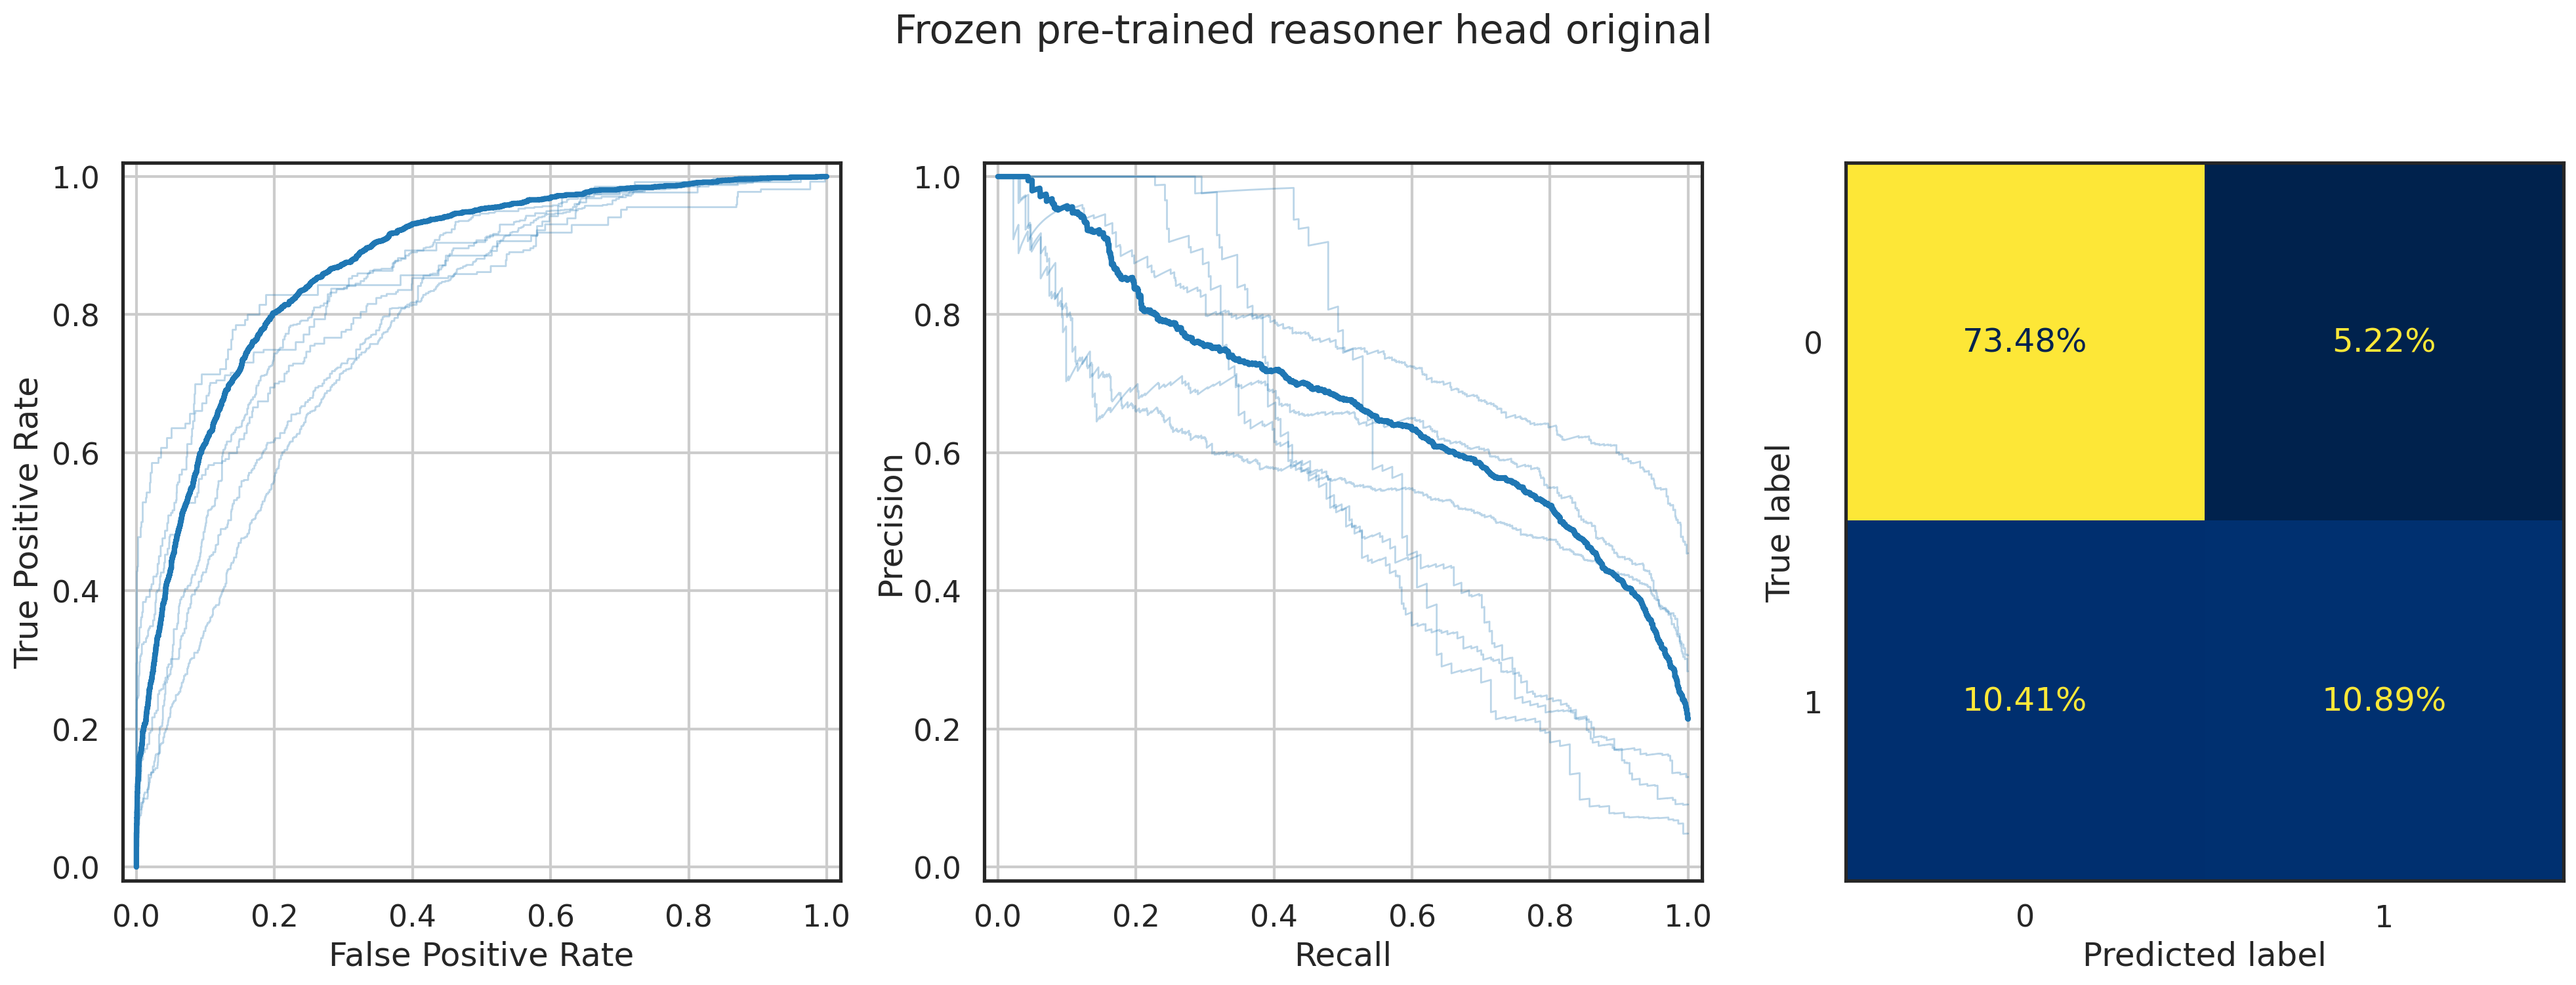

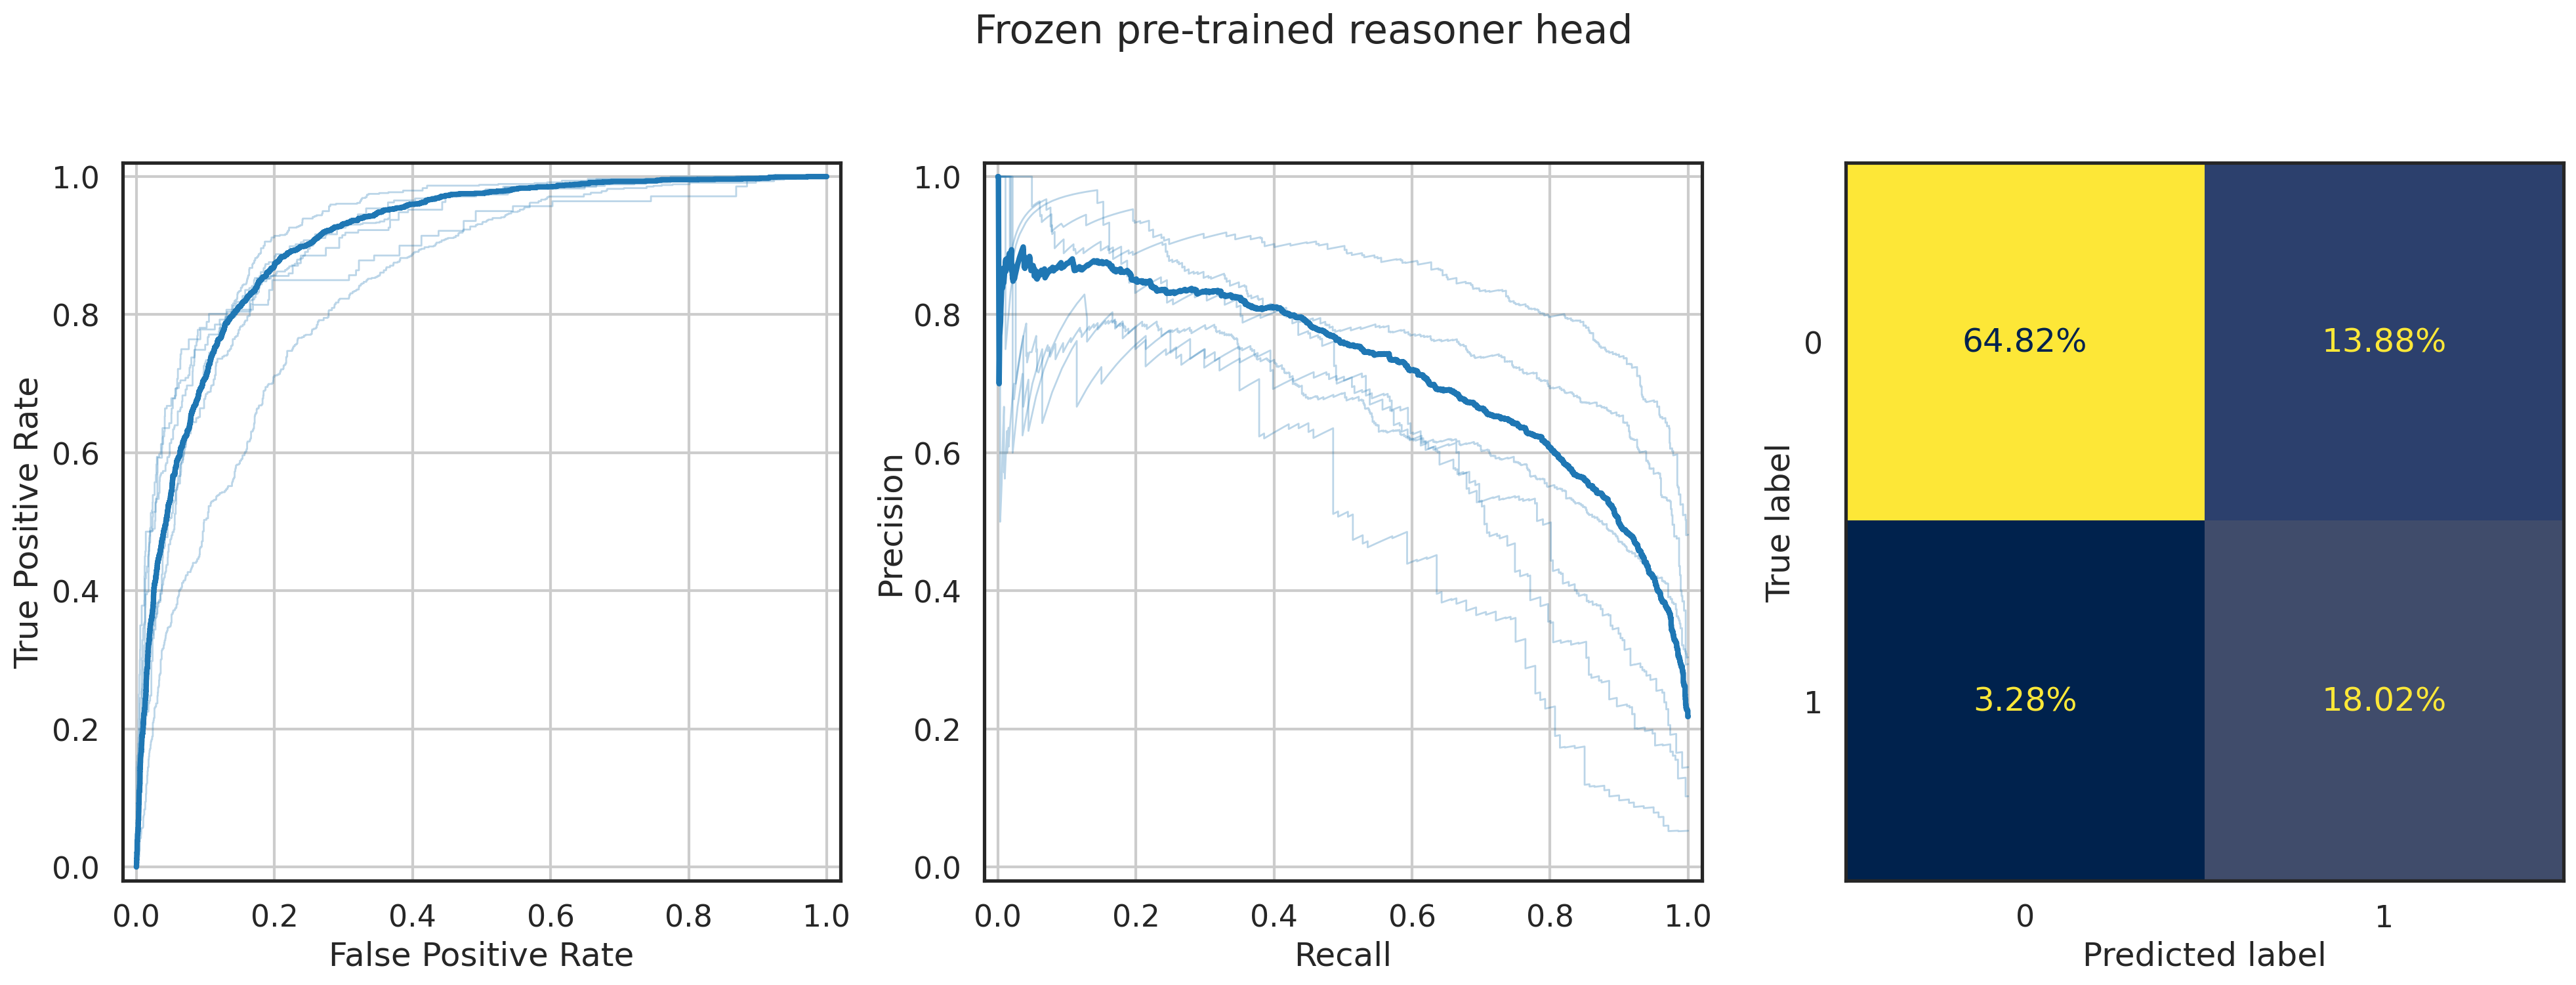

In [12]:
titles = 'Expected', 'Frozen pre-trained reasoner head original', 'Frozen pre-trained reasoner head'
logs = transfer_log_orig, transfer_log
heads = transfer_r_orig_head, transfer_r_head
embeddings = transfer_r_orig_embs, transfer_r_embs

base = 'local/out/exp/' + ts
mkdirp(base)
print(base)

for head, embs, log, title in zip(heads, embeddings, logs, titles[1:]):
    print('------')
    with T.no_grad():
        head.eval()
        if title == 'Frozen pre-trained reasoner head original':
            _, _, Y_te = eval_batch(head, embs, X_te, y_te, idx_te)
        else:
            _, _, Y_te = eval_batch_mod(head, embs, X_te, y_te, idx_te)

    print(title)
    
    # history_tr = pd.DataFrame(log.history_tr)
    # test_history_by_onto = pd.DataFrame(log.history_vl_by_onto)
    # test_history = pd.DataFrame(log.history_vl)
    test_results = pd.DataFrame(dict(idx_te=idx_te, y_te=y_te, Y_te=Y_te))
    # test_history.to_csv(base+f'/{title} test.csv', index=False)
    # test_history_by_onto.to_csv(base+f'/{title} test by onto.csv', index=False)
    test_results.to_csv(base+f'/{title} test clas.csv', index=False)

    # print('train time', history_tr.groupby('epoch').max().elapsed.sum())
    print(report(ontos, y_te, Y_te, idx_te).round(4))
    plt.suptitle(title)

In [30]:
base = 'local/out/exp/' + 'exp5_frozen_new2'
mkdirp(base)
T.save(transfer_r_embs, base+'/emb_mod_layer.pt')
T.save(transfer_r_orig_embs, base+'/emb_orig_layer.pt')

In [31]:
a = T.load(base+'/emb_orig_layer.pt')

In [32]:
b = T.load(base+'/emb_mod_layer.pt')

In [13]:
for head, embs, log, title in zip(heads, embeddings, logs, titles[1:]):
    df = pd.DataFrame(log.history_vl_by_onto)
    df = df[df.epoch == df.epoch.max()].drop(columns=['epoch', 'run', 'elapsed'])
    df.onto = df.onto.map(onto_names.__getitem__)
    print('-'*10)
    print(title)
    #print(df.agg(['mean', 'std']).round(4).T)
    print(df.round(4))

----------
Frozen pre-trained reasoner head original
       acc      f1    prec  recall  roc_auc  pr_auc      onto
60  0.9130  0.4505  0.8359  0.3084   0.8282  0.5626  wildlife
61  0.9713  0.6091  0.8375  0.4786   0.8808  0.6323  demacare
62  0.7890  0.5631  0.6689  0.4863   0.8427  0.6475     stuff
63  0.7370  0.5306  0.5703  0.4961   0.7776  0.5819       swo
64  0.9350  0.5161  0.7879  0.3838   0.8565  0.6043    ontodt
65  0.7177  0.6575  0.7163  0.6076   0.8021  0.7543     pizza


AttributeError: 'tuple' object has no attribute 'history_vl_by_onto'

In [ ]:
import numpy as np
import pandas as pd

# Upewnij się, że Y_te i y_te są numpy array
Y_te_2 = np.array(Y_te)
y_te_2 = np.array(y_te)
X_te_2 = np.array(X_te)

# Oblicz błędne predykcje
błędne_predykcje = abs(Y_te_2 - y_te_2) > 0.5

# Wyodrębnij rekordy, na których model popełnił błąd
rekordy_z_błędem = X_te_2[błędne_predykcje, :]

# Połącz rekordy z ich prawdziwymi etykietami i predykcjami
wyniki = pd.DataFrame({
    'Rec': np.arange(len(X_te_2))[błędne_predykcje],
    'True': y_te_2[błędne_predykcje],
    'Pred': Y_te_2[błędne_predykcje],
})

content_df = pd.DataFrame(rekordy_z_błędem, columns=[f'F{i}' for i in range(X_te_2.shape[1])])
wyniki = pd.concat([wyniki.reset_index(drop=True), content_df.reset_index(drop=True)], axis=1)



/tmp/ipykernel_17009/1003111826.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_te_2 = np.array(X_te)


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', '{:0.2f}'.format):  # more options can be specified also
    print(wyniki)

        Rec  True  Pred F0                                                 F1  \
0        10     0  0.99  0  (4, (3, (7, 36, (4, (3, (4, (7, 5, (3, 228)), ...   
1        13     1  0.49  0  (3, (7, 2, (3, (4, (3, 3), (4, 65, (3, (4, 72,...   
2        15     1  0.10  0  (4, 2527, (7, 26, (3, (4, (3, (4, 3326, 839)),...   
3        17     0  0.97  0  (4, (4, (7, 45, (3, 82)), (3, (7, 28, (4, (3, ...   
4        30     0  1.00  0  (4, (4, (7, 23, (3, (4, (3, 91), (3, (7, 23, (...   
5        33     0  0.70  0  (4, (4, (4, 21, 24), (7, 1, (3, (7, 3, (7, 1, ...   
6        37     1  0.47  0                                               2391   
7        48     1  0.08  0                    (3, (7, 20, (7, 5, (3, 2722))))   
8        51     0  0.55  0  (3, (7, 15, (7, 12, (4, 55, (7, 43, (4, (3, (7...   
9        60     1  0.00  0                         (7, 2, (7, 0, (7, 7, -2)))   
10       64     0  0.90  0  (4, (7, 3, (7, 1, (7, 3, (3, 393)))), (4, (4, ...   
11       73     0  0.80  0  

In [14]:
T.sigmoid( transfer_r_head.encode( core(X_te[0]), transfer_r_embs[idx_te[0]]))


tensor([0.0003], grad_fn=<SigmoidBackward0>)

In [ ]:
T.sigmoid(transfer_r_orig_head.encode( core(X_te[0]), transfer_r_embs[idx_te[0]]))


tensor([0.1417], grad_fn=<SigmoidBackward0>)

In [ ]:
T.set_printoptions(precision=4)

In [16]:
import random

encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(input)
print(transfer_r_head.and_nn(im_mod( input, input)))
F.l1_loss(input, transfer_r_head.and_nn(im_mod(input, input)))

tensor([-0.0511, -0.1211, -0.0654, -0.0911,  0.0072,  0.0756, -0.1212, -0.2227,
         0.2177,  0.0637], grad_fn=<SelectBackward0>)
tensor([ 0.0208, -0.0464,  0.0136, -0.2232,  0.1248, -0.0876, -0.0981, -0.1254,
         0.0552,  0.1136], grad_fn=<AddBackward0>)


tensor(0.0971, grad_fn=<L1LossBackward0>)

In [21]:
import random

encoder = transfer_r_orig_embs[int(np.round(random.random() * (len(transfer_r_orig_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(input)
print(transfer_r_orig_head.and_nn(im_mod( input, input)))
F.l1_loss(input, transfer_r_orig_head.and_nn(im_mod(input, input)))

tensor([-0.0905, -0.1216,  0.0874,  0.0738, -0.0981,  0.1121,  0.0544,  0.0596,
        -0.0674, -0.1553], grad_fn=<SelectBackward0>)
tensor([-0.1230, -0.1023,  0.0144,  0.0298,  0.2328, -0.1090,  0.1812, -0.1533,
         0.1497,  0.0600], grad_fn=<AddBackward0>)


tensor(0.1493, grad_fn=<L1LossBackward0>)

In [22]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(transfer_r_head.bot_concept[0])
print(transfer_r_head.and_nn(im_mod(transfer_r_head.bot_concept[0], input)))
print(F.l1_loss(transfer_r_head.and_nn(im_mod(transfer_r_head.bot_concept[0], input)), transfer_r_head.bot_concept[0]))

tensor([ 0.2295,  0.2580,  0.0668, -0.4629,  0.3658, -0.0904,  0.0320,  0.1133,
        -0.1736, -0.0952], grad_fn=<SelectBackward0>)
tensor([ 0.2577,  0.2991,  0.0763, -0.4826,  0.4066, -0.0791,  0.0531,  0.1560,
        -0.2058, -0.1239], grad_fn=<AddBackward0>)
tensor(0.0275, grad_fn=<L1LossBackward0>)


In [24]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(input)
print(transfer_r_head.and_nn(im_mod(transfer_r_head.top_concept[0], input)))
print(F.l1_loss(transfer_r_head.and_nn(im_mod(transfer_r_head.top_concept[0], input)), input))

tensor([-0.0397, -0.1258, -0.0756, -0.0308,  0.1078,  0.2080, -0.1849, -0.1588,
        -0.1912, -0.0831], grad_fn=<SelectBackward0>)
tensor([-0.0028, -0.0221, -0.0165, -0.0471,  0.0576,  0.0213, -0.0811, -0.0585,
        -0.0458,  0.0203], grad_fn=<AddBackward0>)
tensor(0.0906, grad_fn=<L1LossBackward0>)


In [28]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(transfer_r_head.bot_concept[0])
output = transfer_r_head.and_nn(im_mod(transfer_r_head.not_nn(input), input))
print(output)
print(F.l1_loss(output, input))


tensor([ 0.2295,  0.2580,  0.0668, -0.4629,  0.3658, -0.0904,  0.0320,  0.1133,
        -0.1736, -0.0952], grad_fn=<SelectBackward0>)
tensor([ 0.0526, -0.0388,  0.0451, -0.2673,  0.1351, -0.1221, -0.1137, -0.0694,
         0.0016,  0.1015], grad_fn=<AddBackward0>)
tensor(0.1229, grad_fn=<L1LossBackward0>)


In [29]:
print(transfer_r_head.bot_concept[0])
output = transfer_r_head.not_nn(transfer_r_head.top_concept[0])
print(output)
print(F.l1_loss(transfer_r_head.bot_concept[0], output))

tensor([ 0.2295,  0.2580,  0.0668, -0.4629,  0.3658, -0.0904,  0.0320,  0.1133,
        -0.1736, -0.0952], grad_fn=<SelectBackward0>)
tensor([ 0.2295,  0.2578,  0.0670, -0.4623,  0.3658, -0.0905,  0.0321,  0.1133,
        -0.1733, -0.0952], grad_fn=<SqueezeBackward3>)
tensor(0.0002, grad_fn=<L1LossBackward0>)


In [ ]:
print(transfer_r_head.top_concept[0])
output = transfer_r_head.not_nn(transfer_r_head.bot_concept[0])
print(output)
print(F.l1_loss(transfer_r_head.top_concept[0], output))

tensor([-0.0591, -0.3377, -0.0532,  0.4513,  0.0746,  0.3900,  1.1205, -0.0056,
        -0.2022,  0.4371], grad_fn=<SelectBackward0>)
tensor([-0.0592, -0.3378, -0.0563,  0.4336,  0.0745,  0.3911,  1.0568, -0.0053,
        -0.2060,  0.4157], grad_fn=<SqueezeBackward3>)
tensor(0.0112, grad_fn=<L1LossBackward0>)


In [ ]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input1 = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input2 = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input3 = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(transfer_r_head.and_nn(im_mod(input1, transfer_r_head.and_nn(im_mod(input2, input3)))))
print(transfer_r_head.and_nn(im_mod(transfer_r_head.and_nn(im_mod(input1, input2)), input3)))


F.mse_loss(transfer_r_head.and_nn(im_mod(input1, transfer_r_head.and_nn(im_mod(input2, input3)))), transfer_r_head.and_nn(im_mod(transfer_r_head.and_nn(im_mod(input1, input2)), input3)))

tensor([ 0.1749, -0.0362,  0.1390, -0.2454,  0.2006, -0.0830, -0.0510, -0.0508,
        -0.0548,  0.0156], grad_fn=<AddBackward0>)
tensor([ 0.1786, -0.0818,  0.1513, -0.2225,  0.1921, -0.1127, -0.0595, -0.0493,
        -0.0612,  0.0300], grad_fn=<AddBackward0>)


tensor(0.0004, grad_fn=<MseLossBackward0>)

In [ ]:
encoder = transfer_r_embs[int(np.round(random.random() * (len(transfer_r_embs ) - 1) , 0))]
input = encoder.concepts[ int(np.round( random.random() * encoder.n_concepts , 0) - 1) ]

print(transfer_r_head.and_nn(im_mod(input1, input3)))
print(transfer_r_head.and_nn(im_mod(input3, input1)))

F.mse_loss(transfer_r_head.and_nn(im_mod(input1, input3)), transfer_r_head.and_nn(im_mod(input3, input1)))

F.mse_loss(transfer_r_head.and_nn(im_mod(input1, input3)), transfer_r_head.and_nn(im_mod(input3, input1)))

tensor([ 0.0861, -0.2157,  0.1423, -0.1768,  0.1034, -0.1396, -0.1213, -0.1786,
         0.0665,  0.1699], grad_fn=<AddBackward0>)
tensor([ 0.0975, -0.2329,  0.1447, -0.1777,  0.0922, -0.1304, -0.1345, -0.1749,
         0.0758,  0.1883], grad_fn=<AddBackward0>)


tensor(0.0001, grad_fn=<MseLossBackward0>)

In [ ]:
print(input1)
print(transfer_r_head.and_nn(im_mod(input1, transfer_r_head.top_concept[0])))

F.mse_loss(input1, transfer_r_head.and_nn(im_mod(input1, transfer_r_head.top_concept[0])))

tensor([-0.1244, -0.0855, -0.0461, -0.1073, -0.1299, -0.2016, -0.1863, -0.2894,
         0.2920,  0.0624], grad_fn=<SelectBackward0>)
tensor([-0.1090, -0.2141, -0.0069, -0.0151, -0.1210, -0.1276, -0.1408, -0.2033,
         0.2038,  0.1300], grad_fn=<AddBackward0>)


tensor(0.0054, grad_fn=<MseLossBackward0>)